In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import numpy as np
import matplotlib.pyplot as plt

import mahakala as ma

from mahakala.grmhd.athenak import AthenakFluidModel
from mahakala.electrons import rlow_rhigh_model
from mahakala.transfer import synchrotron_coefficients

In [51]:
fname = '../data/torus.mhd_w_bcc.01500.athdf'
bhspin = 0.9
fluid_gamma = 13./9

fluid_model = AthenakFluidModel(fname, bhspin)

100%|██████████| 456/456 [00:00<00:00, 493.12it/s]


In [52]:
observing_frequency = 230.e9
Mass_scale = 5e+24
M_bh = 6.2e9 * 1.989e33
r_high = 40

inclination_in_degrees = 60
distance_in_rg = 1000

fov = 10
number_pixels_across = 80

s0 = ma.initialize_geodesics_at_camera(bhspin, inclination_in_degrees, distance_in_rg, -fov, fov, number_pixels_across)

In [42]:
S, final_dt = ma.geodesic_integrator(10000, s0, 40, 1e-4, bhspin)

In [6]:
fluid_scalars = fluid_model.get_fluid_scalars_from_geodesics(S)

  0%|          | 0/456 [00:00<?, ?it/s]

100%|██████████| 456/456 [00:05<00:00, 84.98it/s]


In [84]:
# compute supplementary quantities from fluid data and scales

bsq = fluid_scalars['b'] * fluid_scalars['b']

beta = fluid_scalars['u'] * (fluid_gamma - 1.) / bsq / 0.5
beta.at[np.isnan(beta)].set(0.)

sigma = bsq / fluid_scalars['dens']
sigma.at[np.isnan(sigma)].set(0.)

Theta_e = rlow_rhigh_model(fluid_scalars['dens'], fluid_scalars['u'], beta, r_high=r_high)

local_nu = - fluid_scalars['kdotu'] * observing_frequency
gamma_inv_data = local_nu / observing_frequency

units = fluid_model.get_units(M_bh, Mass_scale)

Ne_in_cgs = units['Ne_unit'] * fluid_scalars['dens']
B_in_gauss = units['B_unit'] * fluid_scalars['b']
pitch_angle = fluid_scalars['pitch_angle']

In [85]:
emissivity_jax, absorptivity_jax = synchrotron_coefficients(Ne_in_cgs, Theta_e, B_in_gauss, pitch_angle, local_nu)

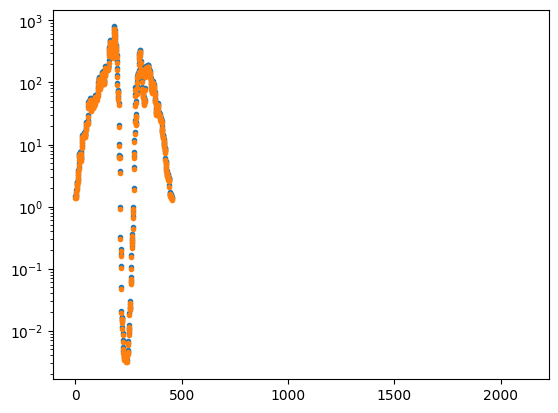

In [383]:
pidx = 174

plt.plot(ne_data[:, pidx], '.')
plt.plot(Ne_in_cgs[:, pidx], '.')

#plt.plot(B_in_gauss[:, pidx])
#plt.plot(bfield[:, pidx])

#plt.plot(beta[:, pidx])
#plt.plot(beta_data[:, pidx])

plt.yscale('log')
#plt.ylim(1.e2, 3)

In [325]:
prim_data = fluid_model.get_prims_from_geodesics(S, profile=True)

100%|██████████| 456/456 [00:05<00:00, 89.85it/s]


Time to compute meshblock indices: 5.092602968215942
Time to compute primitives: 0.5080239772796631


In [342]:
tensorial_data = fluid_model.compute_tensorial(S, prim_data)

AttributeError: 'AthenakFluidModel' object has no attribute 'compute_tensorial'

In [326]:
fluid_scalars = fluid_model.get_fluid_scalars_from_geodesics(S, profile=True)

# [prims[:, irho], prims[:, iu], pitch_angle, kdotu, kdotb, bdotb]
# checked: kdotu, kdotb, bdotb

  0%|          | 0/456 [00:00<?, ?it/s]

100%|██████████| 456/456 [00:05<00:00, 85.63it/s]


Time to compute meshblock indices: 5.343536853790283
Time to compute scalar data: 0.7264771461486816


In [200]:
fluid_scalars.keys()

dict_keys(['dens', 'u', 'pitch_angle', 'kdotu', 'b'])

In [201]:
tensorial_data.keys()

dict_keys(['ucon', 'bcon', 'pitch_angle', 'udotu', 'kdotu', 'kdotb', 'bdotb', 'UuUu', 'final_M'])

In [205]:
tensorial_data['pitch_angle'].shape, fluid_scalars['pitch_angle'].shape

((1588, 1600), (1588, 1600))

In [265]:
for step in range(1588):
    diff_pa = np.allclose(tensorial_data['pitch_angle'][step], fluid_scalars['pitch_angle'][step])
    diff_kdotu = np.allclose(tensorial_data['kdotu'][step], fluid_scalars['kdotu'][step])
    diff_b = np.allclose(np.sqrt(tensorial_data['bdotb'][step]), fluid_scalars['b'][step])

    if not diff_pa or not diff_kdotu or not diff_b:
        print(step, diff_pa, diff_kdotu, diff_b)
        
        break

70 False True True


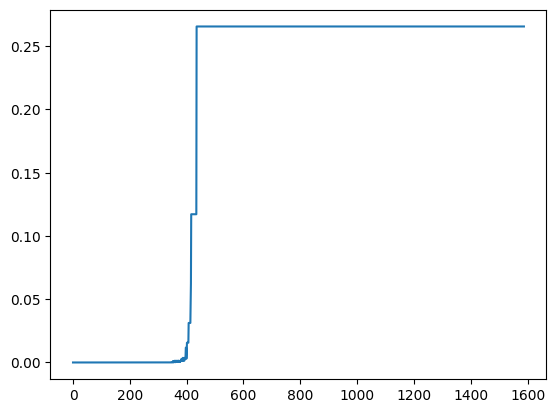

In [274]:
diffs = []
for step in range(tensorial_data['bdotb'].shape[0]):
    diffs.append(np.max(np.abs(tensorial_data['kdotu'][step] - fluid_scalars['kdotu'][step])))
    #diffs.append(np.max(np.abs(tensorial_data['pitch_angle'][step] - fluid_scalars['pitch_angle'][step])))
    #diffs.append(np.max(np.abs(np.sqrt(tensorial_data['bdotb'][step]) - fluid_scalars['b'][step])))
plt.plot(diffs)

(0.0, 2.0)

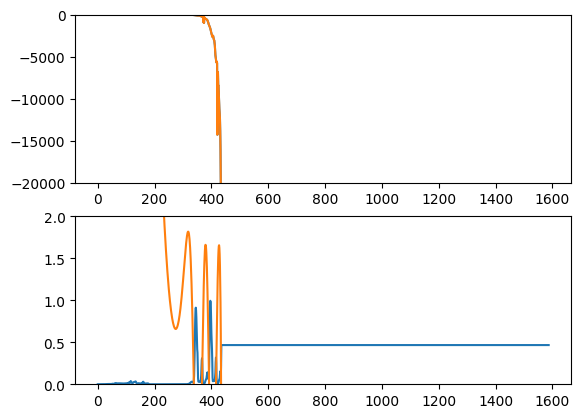

In [288]:
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

ax1.plot(tensorial_data['kdotu'][:, 1024])
ax1.plot(fluid_scalars['kdotu'][:, 1024])

ax1.set_ylim(-20000, 0)

#ax2.plot(S[:, 1024, 0])

ax2.plot(fluid_scalars['dens'][:, 1024])

ax2.plot(S[:, 1024, 1])
ax2.set_ylim(0, 2)


(1020.0, 1040.0)

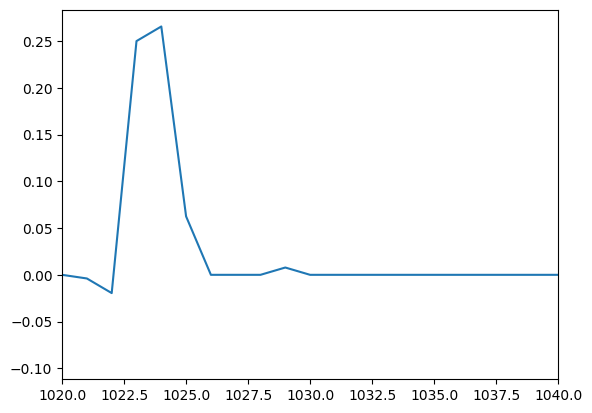

In [280]:
step = 600
plt.plot(tensorial_data['kdotu'][step] - fluid_scalars['kdotu'][step])
plt.xlim(1020, 1040)

#tensorial_data['pitch_angle'][step] - fluid_scalars['pitch_angle'][step].shape

#fluid_scalars['pitch_angle'][step][1058]

In [262]:
npx = 1058
tensorial_data['pitch_angle'][step][npx], fluid_scalars['pitch_angle'][step][npx]

(0.0, Array(0.00034527, dtype=float32))

In [231]:

ipx = 400

for key in ['pitch_angle', 'kdotu']:
    print(np.allclose(tensorial_data[key][:ipx], fluid_scalars[key][:ipx], atol=1e-5))

False
False


In [226]:
for i in range(1600):
    if not np.allclose(tensorial_data['pitch_angle'][70][i], fluid_scalars['pitch_angle'][70][i], atol=1e-4):
        print(i, tensorial_data['pitch_angle'][70][i], fluid_scalars['pitch_angle'][70][i])

In [174]:
fluid_scalars[:, :, 2][10, 254]

Array(-0.8300037, dtype=float32)

In [173]:
tensorial_data['pitch_angle'][10, 254]

2.549910327614144

In [162]:
tensorial_data.keys()

dict_keys(['ucon', 'bcon', 'pitch_angle', 'udotu', 'kdotu', 'kdotb', 'bdotb', 'UuUu', 'final_M'])

In [161]:
istep = 10
ipx = 234

fluid_scalars['prims'][istep, ipx], tensorial_data['bcon'][:, istep, ipx]

(Array([-1.4163232e-06, -1.3280218e-04, -5.2296702e-05, -3.0110543e-06,
         1.1159096e-06, -1.3306091e-04, -5.2293599e-05, -3.1636741e-06],      dtype=float32),
 array([-1.41632347e-06, -1.32802175e-04, -5.22966984e-05, -3.01105410e-06]))

In [ ]:
## end scratch

In [398]:
import mahakala.transfer

from tqdm import tqdm

In [409]:
nsteps, npx, _ = S.shape

synemiss_data = np.empty((nsteps, npx))
for i in tqdm(range(nsteps)):
    synemiss_data[i] = mahakala.transfer.emission_coefficient_old(ne_data[i], t_electron[i], bfield[i], local_nu[i], beta_data[i], fluid_scalars['pitch_angle'][i])
index = np.where(np.isnan(synemiss_data) == True)  # is the == True needed?
synemiss_data[index[0], index[1]] = 0.0
del index

absorption_data = np.zeros((nsteps, npx))
for i in tqdm(range(nsteps)):
    absorption_data[i] = mahakala.transfer.absorption_coefficient(t_electron[i,:], synemiss_data[i,:], local_nu[i,:], beta_data[i,:])
index = np.where(np.isnan(absorption_data) == True)
absorption_data[index[0], index[1]] = 0.0
del index

  0%|          | 0/2121 [00:00<?, ?it/s]

 17%|█▋        | 363/2121 [00:01<00:08, 198.74it/s]/home/george/sites/liamedeiros/Mahakala/mahakala/transfer.py:98: RuntimeWarning: invalid value encountered in power
  var = np.exp(-np.power(X,1./3.))
/home/george/sites/liamedeiros/Mahakala/mahakala/transfer.py:99: RuntimeWarning: invalid value encountered in power
  synemiss = Ne*nus*np.power(jnp.sqrt(X)+np.power(2., 11./12.)*np.power(X,1./6.),2.)/(special.kn(2,1./thetae))
100%|██████████| 2121/2121 [00:05<00:00, 353.60it/s]


In [410]:
synemiss_data_old = synemiss_data.copy()

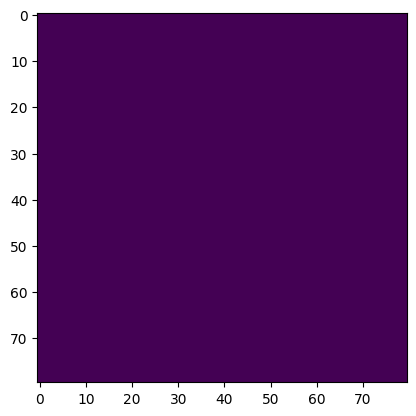

In [406]:
plt.imshow(synemiss_data.sum(axis=0).reshape((80, 80)))
plt.imshow(absorption_data.sum(axis=0).reshape((80, 80)))

In [19]:
nsteps, npx, _ = S.shape

synemiss_data = np.empty((nsteps, npx))
for i in tqdm(range(nsteps)):
    synemiss_data[i] = mahakala.transfer.emission_coefficient(ne_data[i], t_electron[i], bfield[i], local_nu[i], beta_data[i], tensorial_data['pitch_angle'][i])
index = np.where(np.isnan(synemiss_data) == True)  # is the == True needed?
synemiss_data[index[0], index[1]] = 0.0
del index

absorption_data = np.zeros((nsteps, npx))
for i in tqdm(range(nsteps)):
    absorption_data[i] = mahakala.transfer.absorption_coefficient(t_electron[i,:], synemiss_data[i,:], local_nu[i,:], beta_data[i,:])
index = np.where(np.isnan(absorption_data) == True)
absorption_data[index[0], index[1]] = 0.0
del index

  0%|          | 0/10001 [00:00<?, ?it/s]

  3%|▎         | 318/10001 [00:00<00:15, 629.66it/s]/home/george/sites/liamedeiros/Mahakala/mahakala/transfer.py:56: RuntimeWarning: invalid value encountered in power
  var = np.exp(-np.power(X,1./3.))
/home/george/sites/liamedeiros/Mahakala/mahakala/transfer.py:57: RuntimeWarning: invalid value encountered in power
  synemiss = Ne*nus*np.power(jnp.sqrt(X)+np.power(2., 11./12.)*np.power(X,1./6.),2.)/(special.kn(2,1./thetae))
/home/george/sites/liamedeiros/Mahakala/mahakala/transfer.py:54: RuntimeWarning: divide by zero encountered in divide
  X=nu/nus
/home/george/sites/liamedeiros/Mahakala/mahakala/transfer.py:57: RuntimeWarning: invalid value encountered in multiply
  synemiss = Ne*nus*np.power(jnp.sqrt(X)+np.power(2., 11./12.)*np.power(X,1./6.),2.)/(special.kn(2,1./thetae))
  0%|          | 0/10001 [00:00<?, ?it/s]/home/george/sites/liamedeiros/Mahakala/mahakala/transfer.py:64: RuntimeWarning: divide by zero encountered in divide
  B_nu = (2*HPL*nu**3/CL**2)/(pow(np.e,HPL*nu/(KB*t_

In [20]:
final_I = mahakala.transfer.solve_specific_intensity(nsteps, synemiss_data, absorption_data, local_nu, tensorial_data['kdotu'], final_dt, M_BH)

In [22]:
final_image = final_I.reshape((40, 40))

In [42]:
final_I2 = mahakala.transfer.solve_specific_intensity_new2(nsteps, synemiss_data, absorption_data, tensorial_data['kdotu'], final_dt, M_BH)

UnboundLocalError: cannot access local variable 'val' where it is not associated with a value

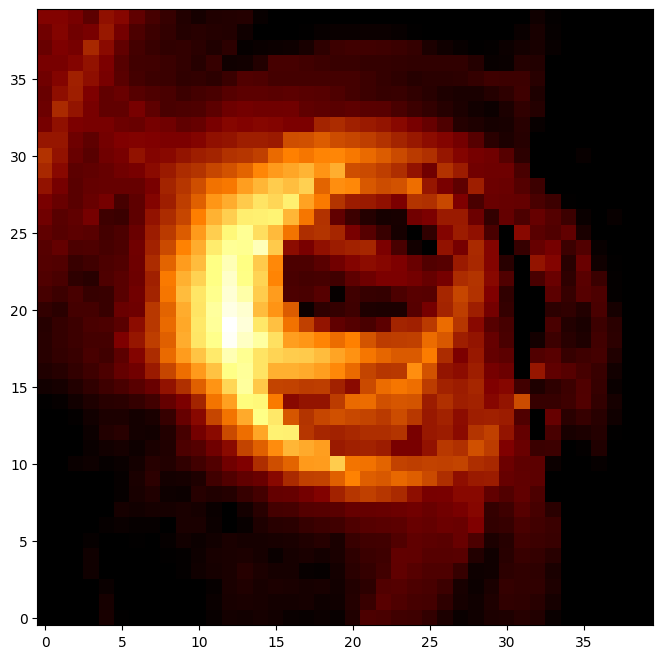

In [33]:
fig = plt.figure(figsize=(8, 8), facecolor='w')

final_image = final_image / np.max(final_image)

ax1 = plt.subplot(1, 1, 1)
ax1.imshow(np.log10(final_image).T, cmap='afmhot', vmin=-4, vmax=0, origin='lower')

# tests below

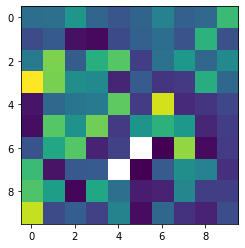

In [228]:
ax1 = plt.subplot(1, 1, 1)

ax1.imshow(tensorial_data['pitch_angle'].min(axis=0).reshape((10, 10)))

In [101]:
from jax import jit, vmap

@jit
def vec_metric(X, bhspin):
    return vmap(mahakala.geodesics.metric, in_axes=(0, None))(X, bhspin)

@jit
def vec_imetric(X, bhspin):
    return vmap(mahakala.geodesics.imetric, in_axes=(0, None))(X, bhspin)

In [102]:
final_M = np.zeros((len(S),len(S[0]),4))
for i in tqdm(range(0,len(S))):
    final_M[i,:,:] = vec_imetric(S[i,:,:4], bhspin)[:,0,:]

100%|██████████| 10001/10001 [00:04<00:00, 2123.72it/s]


In [205]:
xpos_vec = S[:, :, :4]

xs = xpos_vec[:, :, 1]
ys = xpos_vec[:, :, 2]
zs = xpos_vec[:, :, 3]

for j in range(100):
    if np.isnan(np.min(xs[:, j])):
        print(j)
    #print(j, np.min(xs[:, j]))

65
74


In [206]:
len(select_geodesic[:, 0, 1])

419

In [207]:
len(final_dt[:, 64])

10000

In [208]:
tidx = 417
xs[tidx, 65], final_dt[tidx, 65]

(-1.8132638931274414, 0.0)

In [211]:
final_dt[:, 65]

array([-24.96421991, -24.34260941, -23.7364769 , ...,          nan,
                nan,          nan])

(410.0, 425.0)

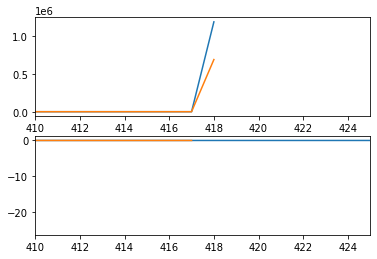

In [232]:
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

ax1.plot(xs[:, 65])
ax2.plot(final_dt[:, 65])
ax1.plot(select_geodesic[:, 0, 1])
ax2.plot(select_dt_final[:, 0])

xlim = [410, 425]

ax1.set_xlim(*xlim)
ax2.set_xlim(*xlim)

In [152]:
select_geodesic.shape

(419, 1, 8)

In [155]:
np.nanmin(select_geodesic[:, 0, 1])

-1.7934848070144653

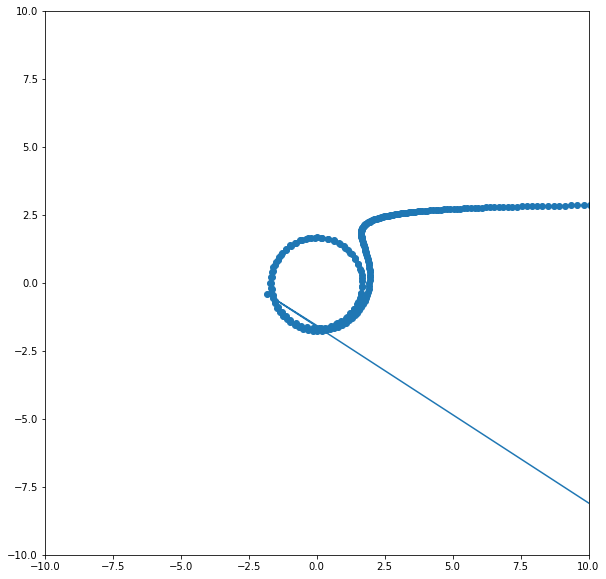

In [233]:
plt.figure(figsize=(10, 10), facecolor='w')

ax1 = plt.subplot(1, 1, 1)

ax1.plot(xs[:, 65], ys[:, 65], '-o')

plim = 10
ax1.set_xlim(-plim, plim)
ax1.set_ylim(-plim, plim)

ax1.set_aspect('equal')

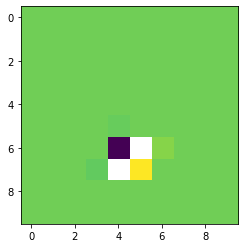

In [76]:
ax1 = plt.subplot(1, 1, 1)

ax1.imshow(local_nu.sum(axis=0).reshape((10, 10)))

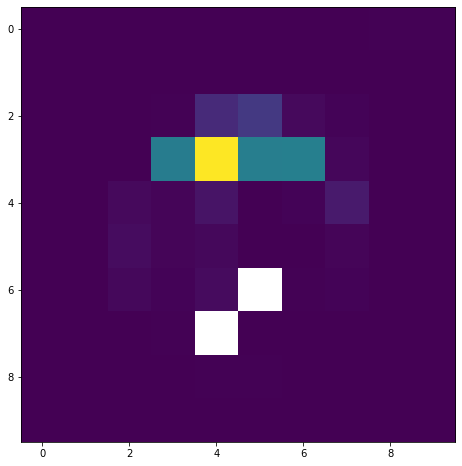

In [ ]:

        Mass_scale = 5e+24

        bfield = np.sqrt(BuBu) *  c * np.sqrt(pow(G*M_BH/c**2,-3) * Mass_scale * 4 * np.pi)

        ne_data = Mass_scale * densff_data * pow(G*M_BH/c**2,-3)  * 1/(1.67 * 1e-24 +  9.1094 * 1e-28)

        R_imp = ((R_high * (beta_data)**2/(1 + (beta_data)**2)) + 1/(1+(beta_data)**2))

        t_electron = c**2 * (m_p  * internal_u_data * (4/3 -1) * (5/3-1))/(Kb * densff_data * ((5/3-1) + (4/3-1) * R_imp))

        thetae = Kb * t_electron/(m_e*c**2)

        #index = np.where(np.isnan(t_electron)== True)
        #t_electron[index[0],index[1]] = 0

        del R_imp

        synemiss_data = np.empty((len(S),LEN))

        for i in range(len(S)):
            synemiss_data[i,:] = synemiss(ne_data[i,:], t_electron[i,:],bfield[i,:],nu[i,:],beta_data[i,:], observer_angle[i,:])

        index = np.where(np.isnan(synemiss_data)==True)
        synemiss_data[index[0],index[1]] = 0.0

        del index
        absorption_data   = np.zeros((len(S), LEN))

        #for i in range(len(S)):
        #    absorption_data[i,:] = absorption_coeff(t_electron[i,:], synemiss_data[i,:], nu[i,:],beta_data[i,:])



        index = np.where(np.isnan(absorption_data)==True)
        absorption_data[index[0],index[1]] = 0.0

        del index

        grav_synchrotron = synemiss_data/nu**2

        index = np.where(np.isnan(grav_synchrotron) == True)

        grav_synchrotron[index[0],index[1]] = 0.0


        index = np.where(np.isnan(gamma_inv_data) == True)
        gamma_inv_data[index[0],index[1]] = 0.0


        index = np.where(sigma_data > 1)
        ne_data[index[0],index[1]] = 0.0
        grav_synchrotron[index[0],index[1]] = 0.0
        absorption_data[index[0],index[1]] = 0.0
        synemiss_data[index[0],index[1]] = 0.0

        index = np.where(nu < 0)
        nu[index[0],index[1]] = 0.0

        index = np.where(grav_synchrotron < 0)
        grav_synchrotron[index[0],index[1]] = 0.0

        index = np.where(absorption_data < 0)
        absorption_data[index[0],index[1]] = 0.0

        N = len(S)

        final_I,I_list = specific_intensity(N,synemiss_data,absorption_data,nu,KuUu,final_dt)


In [45]:
local_nu = -tensorial_data['kdotu'] * 230e9
gamma_inv_data = local_nu / 230.e9

"""
beta_data       = internal_u_data/BuBu * (((fluid_gamma) - 1)/0.5)
sigma_data      = BuBu/densff_data

index = np.where(np.isnan(beta_data) == True)
beta_data[index[0],index[1]] = 0
index = np.where(np.isnan(sigma_data) == True)
sigma_data[index[0],index[1]] = 0    """

In [ ]:

    beta_data       = internal_u_data/BuBu * (((fluid_gamma) - 1)/0.5)
    sigma_data      = BuBu/densff_data

    index = np.where(np.isnan(beta_data) == True)
    beta_data[index[0],index[1]] = 0
    index = np.where(np.isnan(sigma_data) == True)
    sigma_data[index[0],index[1]] = 0

    #return S,ne_data,thetae,bfield_data_pmag,num.sqrt(BuBu),sigma_data,beta_data,-KuUu * 230e9

    def pitch_angle(KuUu,KuBu,BuBu):

        angle = KuBu/(abs(KuUu) * np.sqrt(BuBu))

        index = np.where(BuBu == 0)
        angle[index[0],index[1]] = np.cos(np.pi/2)

        index = np.where(abs(angle) > 1.0)
        angle[index[0],index[1]] = angle[index[0],index[1]]/abs(angle[index[0],index[1]])

        return np.arccos(angle)

    observer_angle = pitch_angle(KuUu,KuBu,BuBu)

    del KuBu

    nu = -KuUu * 230e9

    gamma_inv_data = nu/230e9


    R_high_list = [80]

    for R_high in R_high_list:

        Mass_scale = 5e+24

        bfield = np.sqrt(BuBu) *  c * np.sqrt(pow(G*M_BH/c**2,-3) * Mass_scale * 4 * np.pi)

        ne_data = Mass_scale * densff_data * pow(G*M_BH/c**2,-3)  * 1/(1.67 * 1e-24 +  9.1094 * 1e-28)

        R_imp = ((R_high * (beta_data)**2/(1 + (beta_data)**2)) + 1/(1+(beta_data)**2))

        t_electron = c**2 * (m_p  * internal_u_data * (4/3 -1) * (5/3-1))/(Kb * densff_data * ((5/3-1) + (4/3-1) * R_imp))

        thetae = Kb * t_electron/(m_e*c**2)

        #index = np.where(np.isnan(t_electron)== True)
        #t_electron[index[0],index[1]] = 0

        del R_imp

        synemiss_data = np.empty((len(S),LEN))

        for i in range(len(S)):
            synemiss_data[i,:] = synemiss(ne_data[i,:], t_electron[i,:],bfield[i,:],nu[i,:],beta_data[i,:], observer_angle[i,:])

        index = np.where(np.isnan(synemiss_data)==True)
        synemiss_data[index[0],index[1]] = 0.0

        del index
        absorption_data   = np.zeros((len(S), LEN))

        #for i in range(len(S)):
        #    absorption_data[i,:] = absorption_coeff(t_electron[i,:], synemiss_data[i,:], nu[i,:],beta_data[i,:])



        index = np.where(np.isnan(absorption_data)==True)
        absorption_data[index[0],index[1]] = 0.0

        del index

        grav_synchrotron = synemiss_data/nu**2

        index = np.where(np.isnan(grav_synchrotron) == True)

        grav_synchrotron[index[0],index[1]] = 0.0


        index = np.where(np.isnan(gamma_inv_data) == True)
        gamma_inv_data[index[0],index[1]] = 0.0


        index = np.where(sigma_data > 1)
        ne_data[index[0],index[1]] = 0.0
        grav_synchrotron[index[0],index[1]] = 0.0
        absorption_data[index[0],index[1]] = 0.0
        synemiss_data[index[0],index[1]] = 0.0

        index = np.where(nu < 0)
        nu[index[0],index[1]] = 0.0

        index = np.where(grav_synchrotron < 0)
        grav_synchrotron[index[0],index[1]] = 0.0

        index = np.where(absorption_data < 0)
        absorption_data[index[0],index[1]] = 0.0

        N = len(S)

        final_I,I_list = specific_intensity(N,synemiss_data,absorption_data,nu,KuUu,final_dt)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/I_inv_{}_SANE/I_trial_{}.npy".format(R_high,lower_limit/8),final_I)

        '''
        I_inv_val = []
        I_len_iteration = []
        j_inv_val = []
        j_len_iteration = []


        for shell_radii_val in range(97):

            shell_index = np.load("/xdisk/chanc/home/anikets/Checking_shell/new_sims/Radius_Shells/Radius_{}/Radii_Shell_i{}_{}.npy".format(lower_limit/8, inclination, shell_radii_val))
            j_inv_sum = sum(grav_synchrotron[shell_index[0], shell_index[1]])

            if len(shell_index[0]) == 0:
                j_inv_avg = 0
            else:
                j_inv_avg = j_inv_sum

            j_len_iteration.append(len(shell_index[0]))
            j_inv_val.append(j_inv_avg)

            shell_index = np.load("/xdisk/chanc/home/anikets/Checking_shell/new_sims/Inv_Radius_Shells/Inv_Radius_{}/Inv_Radii_Shell_i{}_{}.npy".format(lower_limit/8, inclination, shell_radii_val))

            I_inv_sum = sum(I_list[shell_index[0], shell_index[1]])

            if len(shell_index[0]) == 0:
                I_inv_avg = 0
            else:
                I_inv_avg = I_inv_sum

            I_len_iteration.append(len(shell_index[0]))
            I_inv_val.append(I_inv_avg)

        j_inv_val = np.array(j_inv_val)
        j_len_iteration = np.array(j_len_iteration)

        I_inv_val = np.array(I_inv_val)
        I_len_iteration = np.array(I_len_iteration)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/j_inv_{}_SANE/GRMHD_000{}/j_inv_{}_RADIUS_i{}.npy".format(R_high,GRMHD_file, lower_limit/8, inclination), j_inv_val)
            # Now j_inv_val is an array of shape (485,)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/j_inv_{}_SANE/GRMHD_000{}/j_len_iteration_{}_RADIUS_i{}.npy".format(R_high,GRMHD_file,lower_limit/8, inclination),j_len_iteration)


        np.save("/xdisk/chanc/home/anikets/Checking_shell/I_inv_{}_SANE/GRMHD_000{}/I_inv_{}_RADIUS_i{}.npy".format(R_high,GRMHD_file, lower_limit/8, inclination), I_inv_val)
        # Now j_inv_val is an array of shape (485,)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/I_inv_{}_SANE/GRMHD_000{}/I_len_iteration_{}_RADIUS_i{}.npy".format(R_high,GRMHD_file,lower_limit/8, inclination),I_len_iteration)


        '''

        I_inv_val = []
        I_len_iteration = []
        j_inv_val = []
        j_len_iteration = []



        for shell_theta_val in range(89):

            shell_index = np.load("/xdisk/chanc/home/anikets/Checking_shell/new_sims/Theta_Shells/Theta_{}/Theta_Shell_i{}_{}.npy".format(lower_limit/8,inclination,  shell_theta_val))
            j_inv_sum = sum(grav_synchrotron[shell_index[0], shell_index[1]])

            if len(shell_index[0]) == 0:
                j_inv_avg = 0
            else:
                j_inv_avg = j_inv_sum

            j_len_iteration.append(len(shell_index[0]))
            j_inv_val.append(j_inv_avg)


            shell_index = np.load("/xdisk/chanc/home/anikets/Checking_shell/new_sims/Inv_Theta_Shells/Inv_Theta_{}/Inv_Theta_Shell_i{}_{}.npy".format(lower_limit/8, inclination, shell_theta_val))


            I_inv_sum = sum(I_list[shell_index[0], shell_index[1]])

            if len(shell_index[0]) == 0:
                I_inv_avg = 0
            else:
                I_inv_avg = I_inv_sum

            I_len_iteration.append(len(shell_index[0]))
            I_inv_val.append(I_inv_avg)


        j_inv_val = np.array(j_inv_val)
        j_len_iteration = np.array(j_len_iteration)

        I_inv_val = np.array(I_inv_val)
        I_len_iteration = np.array(I_len_iteration)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/j_inv_{}_SANE/GRMHD_000{}/j_trial_inv_{}_THETA_i{}.npy".format(R_high,GRMHD_file, lower_limit/8, inclination), j_inv_val)
            # Now j_inv_val is an array of shape (485,)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/j_inv_{}_SANE/GRMHD_000{}/j_trial_len_iteration_{}_THETA_i{}.npy".format(R_high,GRMHD_file,lower_limit/8, inclination),j_len_iteration)


        np.save("/xdisk/chanc/home/anikets/Checking_shell/I_inv_{}_SANE/GRMHD_000{}/I_trial_inv_{}_THETA_i{}.npy".format(R_high,GRMHD_file, lower_limit/8, inclination), I_inv_val)
        # Now j_inv_val is an array of shape (485,)

        np.save("/xdisk/chanc/home/anikets/Checking_shell/I_inv_{}_SANE/GRMHD_000{}/I_trial_len_iteration_{}_THETA_i{}.npy".format(R_high,GRMHD_file,lower_limit/8, inclination),I_len_iteration)

        del j_inv_val
        del j_len_iteration
        del I_inv_val
        del I_len_iteration


# checks

In [ ]:
primitive_data_og_40sq = np.load('prim_data_og_40sq.npy', allow_pickle=True).item()

print(np.allclose(primitive_data_og_40sq['dens'], prim_data['dens'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['u'], prim_data['u'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['U1'], prim_data['U1'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['U2'], prim_data['U2'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['U3'], prim_data['U3'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['B1'], prim_data['B1'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['B2'], prim_data['B2'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['B3'], prim_data['B3'], atol=1e-3))